### OpenAI Gym

A toolkit that provides a wide variety of simulated environments used to train agents, compare them, or develop new RL Algorithms

In [1]:
!pip install -q -U gym

In [2]:
!pip install --upgrade pip setuptools wheel

(had to downgrade python env to 3.10 for the below installations)

In [3]:
!pip install -q -U "gym[classic_control,box2d,atari,accept-rom-license]"

In [4]:
!pip install "box2d-py"

In [5]:
import gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

A cartpole is a pole on a moving cart that when the cart is pushed the poll is falling down at an angle

A cartPole environment returns 1D NumPy array containing four floats representing the cart’s horizontal position (0.0 = center), its velocity (positive means right), the angle of the pole (0.0 = vertical), and its angular velocity (positive means clockwise). `reset()` returns a dictionary that may contain extra environment-specific information Atari environments, it contains the number of lives left, in CartPole its empty

In [37]:
obs, info = env.reset(seed=42)

In [38]:
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [39]:
info

{}

In [40]:
img = env.render()
img.shape

(400, 600, 3)

In [41]:
!pip install -q matplotlib

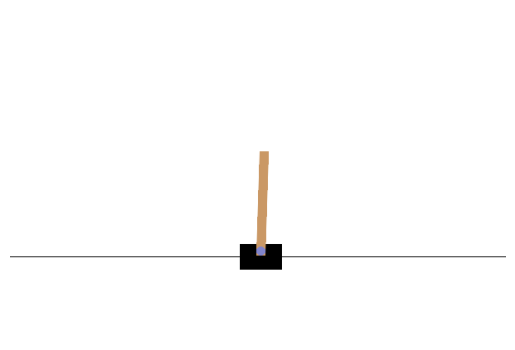

In [42]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis('off')  # Turn off the axis for better visualization
plt.show()

In [43]:
env.action_space # 2 meaning left or right

Discrete(2)

In [47]:
action = 1 # accelerate right
obs, reward, done, truncated, info = env.step(action)

In [48]:
obs

array([ 0.03870419,  0.5777363 ,  0.02017712, -0.8251987 ], dtype=float32)

In [49]:
reward

1.0

In [50]:
done

False

In [51]:
truncated

False

In [52]:
info

{}

In [53]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break
    totals.append(episode_rewards)

In [55]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(np.float64(41.698), np.float64(8.389445512070509), 24.0, 63.0)

With 500 tries this policy never managed to keep the pole upright for more than 63 consecutive steps.

exploration/exploitation dilemma is central in reinforcement learning

In [57]:
!pip install tensorflow

  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 MB 30.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 63.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 36.4 MB/s eta 0:00:00
Using cached werkzeug-3.1.3-py3-none-any.whl (224 kB)
Using cached rich-13.9.4-py3-none-any.whl (2

In [58]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"), # prob of going left
])

If there were more than two possible actions, there would be one output neuron per action, and we would use the softmax activation function instead.

credit assignment problem: when the agent gets a reward, it is hard for it to know which actions should get credited (or blamed) for it. 

### Policy Gradients

PG algorithms optimize the parameters of a policy by following the gradients toward higher rewards

we will pretend for now that whatever action it takes is the right one so we can compute the loss and its gradients

In [60]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [61]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode  in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn
            )
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

compute the sum of future discounted rewards at each step, then normalize all these discounted rewards (the returns) across many episodes by subtracting the mean and dividing by the standard deviation

In [62]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [63]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [65]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [66]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [67]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

training loop

# Understanding Discounted Rewards in Reinforcement Learning

## Key Concepts:
- **Rewards**: Numerical values the agent receives after performing an action. A higher reward is generally better.
- **Discount Factor (γ, gamma)**: A value between 0 and 1 that determines the importance of future rewards compared to immediate rewards.
  - If **γ is close to 0**, the agent prioritizes **immediate rewards** and largely ignores future rewards.
  - If **γ is close to 1**, the agent considers **future rewards almost as important** as immediate rewards.
  
- **Return**: The total amount of reward an agent expects to accumulate over time, starting from a certain state and action. It is the sum of all future rewards, adjusted by the discount factor.

---

## Step-by-Step Example:
In the given example, the agent takes three actions and receives the following rewards:
1. **First action**: +10 reward
2. **Second action**: 0 reward
3. **Third action**: –50 reward  

Let’s assume the discount factor **γ = 0.8**.

The **return** for the first action is calculated as the sum of all future rewards (considering the discount factor):

1. Immediate reward:  
   \[
   +10
   \]
   
2. Second action’s reward is 0, discounted by γ:  
   \[
   γ $\times$ 0 = 0.8 $\times$ 0 = 0
   \]

3. Third action’s reward is –50, discounted by γ²:  
   \[
   γ² $\times$ (-50) = 0.8² $\times$ (-50) = 0.64 $\times$ (-50) = -32
   \]

Summing these:

\[
\text{Return} = 10 + 0 + (-32) = -22
\]

---

## Intuition:
- **When γ is closer to 1** (e.g., 0.99), the agent considers future rewards nearly as important as immediate rewards.
- **When γ is closer to 0** (e.g., 0.1), the agent mostly cares about immediate rewards, and future rewards have little impact.

### Typical Discount Factors:
- **γ = 0.9 to 0.99** is common in RL problems.
- A γ of **0.95** means that rewards **13 steps into the future** count for about half as much as immediate rewards.
- A γ of **0.99** means that rewards **69 steps into the future** count for about half as much.

---

## CartPole Environment:
In **CartPole**, where the goal is to balance a pole on a cart, the effects of actions are **short-term**.  
A **discount factor of 0.95** is reasonable because the agent needs to focus more on the immediate effects of its actions to keep the pole balanced.

---

## Why Does This Matter?
By adjusting **γ**, we control how much the agent "cares" about the future:
- **Higher γ (0.99)** → More long-term planning.
- **Lower γ (0.9 - 0.95)** → More short-term decision-making.

If the problem requires **long-term planning** (like playing chess), a **higher γ** is better.  
For problems with **short-term goals** (like balancing a CartPole), a **lower γ** works well.

---

In [69]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn
    )
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)

    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0
            )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

## **Q-Value Iteration Algorithm Equation**  
The Q-value iteration updates the Q-values iteratively using the Bellman equation:

$$
Q(s, a) \leftarrow \mathbb{E} \left[ r + \gamma \max_{a'} Q(s', a') \mid s, a \right]
$$

where:  
- \( Q(s, a) \) is the Q-value for state \( s \) and action \( a \).  
- \( r \) is the immediate reward received.  
- \( \gamma \) is the discount factor.  
- \( s' \) is the next state.  
- \( a' \) is the next action.  
- \( \max_{a'} Q(s', a') \) ensures we take the best possible future action.

---

## **Value Iteration Algorithm**  
Value iteration updates the value function iteratively:

$$
V(s) \leftarrow \max_{a} \mathbb{E} \left[ r + \gamma V(s') \mid s, a \right]
$$

where:  
- \( V(s) \) is the value of state \( s \), representing the maximum expected return from \( s \).  
- The expectation is taken over possible next states \( s' \) given \( s, a \).  
- The policy chooses the action \( a \) that maximizes future rewards.

---

## **Bellman Optimality Equation**  
The Bellman optimality equation expresses the recursive relationship of the optimal value function:

$$
V^*(s) = \max_{a} \mathbb{E} \left[ r + \gamma V^*(s') \mid s, a \right]
$$

where \( V^*(s) \) represents the optimal value function.

For Q-values, the optimal Q-function follows:

$$
Q^*(s, a) = \mathbb{E} \left[ r + \gamma \max_{a'} Q^*(s', a') \mid s, a \right]
$$

---

## **What is \( \pi^*(a) \)?**  
\( \pi^*(a) \) represents the optimal policy, which selects the best action in a given state:

$$
\pi^*(s) = \arg\max_{a} Q^*(s, a)
$$

This means that the optimal policy selects the action \( a \) that maximizes the Q-value.

---

## **How They Relate and Key Differences**  
- **Bellman optimality equation** defines the best possible value function.  
- **Value iteration** updates values based on Bellman’s equation until convergence.  
- **Q-value iteration** updates Q-values directly instead of state values.  
- **\( \pi^*(s) \)** derives from \( Q^*(s, a) \) by choosing the best action.  

---

## **Example: 3-State MDP**
Consider a simple Markov Decision Process (MDP) with three states \( s_1, s_2, s_3 \) and two actions \( a_1, a_2 \).  
Let’s assume the following rewards and transitions:  
- Taking action \( a_1 \) in \( s_1 \) moves to \( s_2 \) with a reward of \( +5 \).  
- Taking action \( a_2 \) in \( s_2 \) moves to \( s_3 \) with a reward of \( +10 \).  
- \( s_3 \) is a terminal state with zero reward.  
- The discount factor \( \gamma = 0.9 \).

### **1. Bellman Optimality Equation**  
Using the Bellman equation, we start with initial values \( V(s) = 0 \) and iteratively compute:

$$
V(s_2) = \max(5 + 0.9 V(s_3), 0) = 5
$$

$$
V(s_1) = \max(0 + 0.9 V(s_2), 0) = 4.5
$$

### **2. Value Iteration**  
Using value iteration, we compute:

$$
V(s) \leftarrow \max_{a} \mathbb{E} [r + \gamma V(s')]
$$

until convergence.

### **3. Q-Value Iteration**  
Instead of updating \( V(s) \), we update \( Q(s, a) \):

$$
Q(s_1, a_1) = 5 + 0.9 \max(Q(s_2, a_2), 0) = 5 + 0.9 \times 10 = 14
$$

$$
Q(s_2, a_2) = 10 + 0.9 \times 0 = 10
$$

### **4. Deriving the Optimal Policy \( \pi^* \)**  
The optimal policy selects the action with the highest Q-value:

$$
\pi^*(s_1) = \arg\max_{a} Q^*(s_1, a) = a_1
$$

$$
\pi^*(s_2) = \arg\max_{a} Q^*(s_2, a) = a_2
$$

Thus, the optimal strategy is:
- Take \( a_1 \) in \( s_1 \), then take \( a_2 \) in \( s_2 \), reaching \( s_3 \) with maximum rewards.


A MDP manuallly written:

from going from s2 -> s0 after playing action a1 we lookup `transition_probabilities[2][1][0]` = 0.8

to look up corresponding reward we look up `rewards[2][1]`

look up actions in s2: `possible_actions[2]`

In [71]:
transition_probabilities = [
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [72]:
Q_values = np.full((3, 3), -np.inf) # -np.inf impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0 # all possible actions

Q-value iteration algorithm (every state and every possible action)

In [73]:
gamma = 0.90

for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)
            ])

In [74]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

^ when the agent is in state s0 and it chooses action a1, the expected sum of discounted future rewards is approximately 17.0.

For each state, we can find the action that has the highest Q-value:

In [75]:
Q_values.argmax(axis=1) # optimal action for each state

array([0, 0, 1])

### Q-Learning

an adaptation of the Q-value iteration algorithm, it watches the agent play randomly and gradually improving its estimates of the Q-values (Imagine learning to play baseball when your coach is a blindfolded ape.

here we start creating an agent to explore the enviornment (a step function)

In [77]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [78]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

init Q-values and run the Q-learning algorithm with learning rate decay (power scheduling)

In [79]:
alpha0 = 0.05
decay = 0.005
gamma = 0.90
state = 0

for iteration in range(10_000):
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

### Deep Q-learning

In [84]:
input_shape = [4] # env.observation_space.shape
n_outputs = 2 # env.action_space.n

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

ε-greedy

In [86]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()

In [87]:
# replay buffer
from collections import deque

replay_buffer = deque(maxlen=2000)

In [88]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ] # [states, actions, rewards, next_states, dones, truncates]

In [89]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

sample a batch of experiences from the replay buffer and train the DQN by performing a single gradient descent step on this batch

In [95]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds) # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [96]:
# training the model:
for episode in range(600):
    obs, info = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    if episode > 50:
        training_step(batch_size)

^ We run 600 episodes, each for a maximum of 200 steps